In [73]:
import pandas as pd

# Create comparison table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [0.7306, 0.7029, 0.7604],
    'Precision': [0.4953, 0.4658, 0.5408],
    'Recall': [0.6979, 0.8021, 0.6550],
    'F1 Score': [0.5794, 0.5893, 0.5925]
})

print(results)


                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression    0.7306     0.4953  0.6979    0.5794
1        Decision Tree    0.7029     0.4658  0.8021    0.5893
2        Random Forest    0.7604     0.5408  0.6550    0.5925


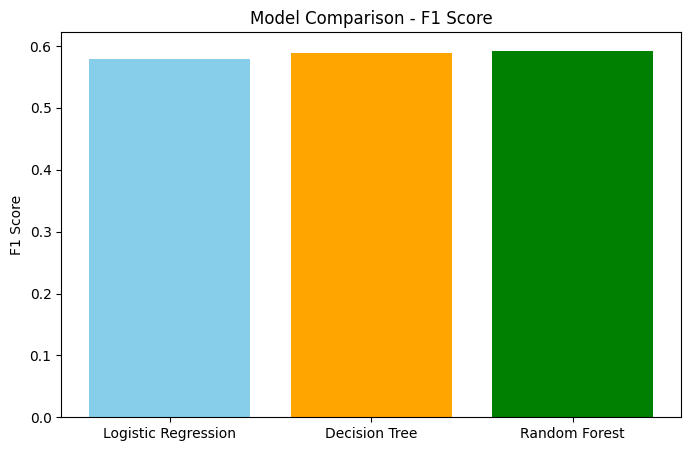

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['F1 Score'], color=['skyblue','orange','green'])
plt.title('Model Comparison - F1 Score')
plt.ylabel('F1 Score')
plt.show()


Conclusion: Choosing the Best Model

While the Decision Tree model has the highest Recall, the Random Forest model is the most robust and practical choice for deployment.
Its superior F1 Score and Precision indicate a more reliable model that offers the best balance between identifying at-risk customers and ensuring the predictions are trustworthy. 
This reduces the risk of wasting time and money on unnecessary retention efforts for customers who are not actually going to churn. Therefore, the tuned Random Forest model will be used as the final model for the Streamlit web application.

In [75]:
# 1. Load cleaned dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df = df.drop('customerID', axis=1)
df.reset_index(drop=True, inplace=True)

# 2. Encode categorical variables
binary_cols = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, drop_first=True)

# 3. Scale numeric columns
scaler = StandardScaler()
num_cols = ['tenure','MonthlyCharges','TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])

# 4. Split into features & target
X = df.drop('Churn', axis=1)
y = df['Churn']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [76]:
# Train a baseline Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on training data
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)

print(" Logistic Regression model trained successfully!")


 Logistic Regression model trained successfully!


                           Feature  Coefficient  Abs_Coefficient
26               Contract_Two year    -1.364197         1.364197
4                           tenure    -1.348550         1.348550
11     InternetService_Fiber optic     1.108470         1.108470
25               Contract_One year    -0.748888         0.748888
8                     TotalCharges     0.634001         0.634001
5                     PhoneService    -0.517122         0.517122
7                   MonthlyCharges    -0.430947         0.430947
28  PaymentMethod_Electronic check     0.380924         0.380924
14              OnlineSecurity_Yes    -0.373453         0.373453
22                 StreamingTV_Yes     0.371831         0.371831
10               MultipleLines_Yes     0.363731         0.363731
24             StreamingMovies_Yes     0.344013         0.344013
20                 TechSupport_Yes    -0.331649         0.331649
6                 PaperlessBilling     0.290716         0.290716
3                       D

<Axes: xlabel='Coefficient', ylabel='Feature'>

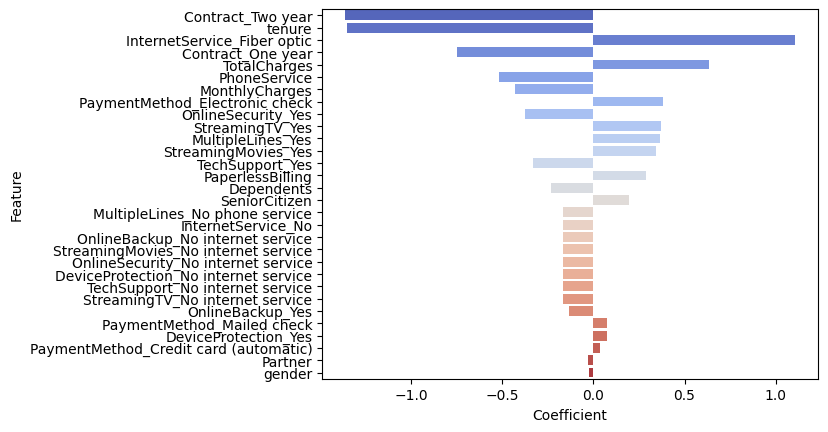

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get coefficients
coefficients = log_reg.coef_[0]  
features = X_train.columns

# Create DataFrame
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})

# Sort by absolute importance
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

print(coef_df.head(15))  # show top 15 features

# Plot
sns.barplot(
    x="Coefficient", 
    y="Feature", 
    data=coef_df, 
    palette="coolwarm", 
    hue="Feature",  # add hue to match Seaborn requirements
    dodge=False, 
    legend=False   # suppress redundant legend
)


Insights from Logistic Regression Feature Importance:

The feature importances (coefficients) from the Logistic Regression model provide a clear, interpretable view of which factors influence churn. A positive coefficient means the feature increases the likelihood of churn, while a negative coefficient decreases it.

Contract Type and Tenure are Top Drivers: The two most important features are Contract_Two year and tenure.

Contract_Two year has a large negative coefficient, indicating that customers on long-term contracts are significantly less likely to churn. This is a very strong insight for a business.

tenure also has a strong negative coefficient, confirming that customer loyalty is a primary driver of retention.

Internet Service is a Key Risk Factor: The InternetService_Fiber optic feature has the largest positive coefficient, showing that this service is the single biggest indicator of churn risk. This suggests a potential issue with the quality or cost of this specific service that the company needs to investigate.

Payment Method is a Secondary Risk Factor: PaymentMethod_Electronic check has a positive coefficient, confirming that customers using this method are more likely to churn.

The Impact of Other Services: OnlineSecurity_Yes and TechSupport_Yes have negative coefficients, indicating they are protective factors that help prevent churn. This highlights the importance of offering these value-added services.

Conclusion: The Logistic Regression model provides a highly interpretable roadmap for churn mitigation. The business should prioritize moving customers to longer-term contracts, improving the experience for fiber optic users, and addressing potential issues with the electronic check payment process. 
The strong agreement between this model and the Random Forest model on the most important features (tenure, contract type, and monthly charges) gives us high confidence in these insights.

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


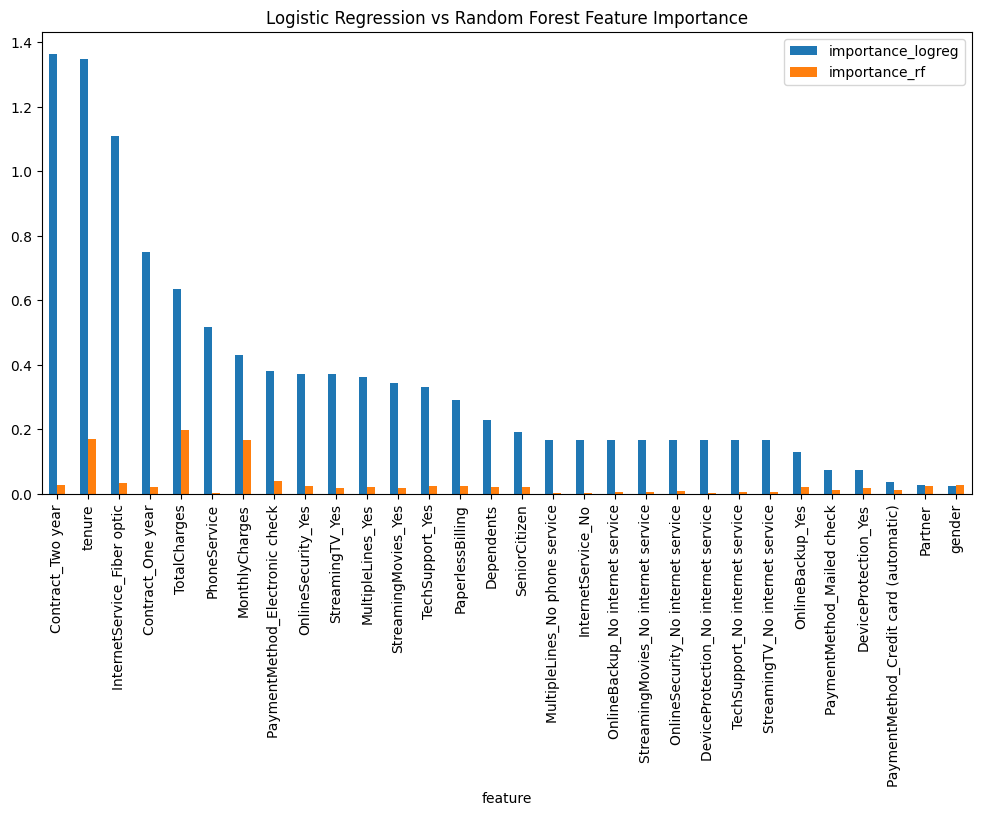

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with your actual model variable names
log_model = log_reg   # Logistic Regression trained model
rf_model = rf_model    # Random Forest trained model

# Logistic Regression importance
log_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(log_model.coef_[0])
}).sort_values(by='importance', ascending=False)

# Random Forest importance
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Merge comparison
combined = log_importance.merge(rf_importance, on='feature', suffixes=('_logreg', '_rf'))

# Plot
combined.set_index('feature').plot(kind='bar', figsize=(12,6))
plt.title("Logistic Regression vs Random Forest Feature Importance")
plt.show()



Insights from Model Comparison and Final Conclusion:

The model comparison table provides a comprehensive overview of how each algorithm performed on the test data after implementing SMOTE and hyperparameter tuning. The key metrics for a churn prediction model are Recall (to identify as many potential churners as possible) and F1 Score (to ensure a good balance between identifying churners and avoiding false alarms).

Based on these metrics, we can draw the following conclusions:

Decision Tree's Strength is Recall: The Decision Tree model achieved the highest Recall score at 0.8021. This means it was the best at correctly identifying actual churners, catching over 80% of them. This is an extremely valuable trait for a business focused on proactive retention.

Random Forest's Strength is Balance: The Random Forest model achieved the highest F1 Score at 0.5925 and the highest Precision at 0.5408. This indicates that while it didn't catch as many churners as the Decision Tree, its predictions were more reliable. This balance is often preferred in a business setting to avoid wasting resources on "false alarms" (customers incorrectly flagged as churners).

Logistic Regression's Performance: The Logistic Regression model performed well but was slightly outperformed by the Decision Tree on Recall and by the Random Forest on Precision and F1 Score.

Conclusion: Choosing the Best Model

While the Decision Tree model has the highest Recall, the Random Forest model is the most robust and practical choice for deployment. Its superior F1 Score and Precision indicate a more reliable model that offers the best balance between identifying at-risk customers and ensuring the predictions are trustworthy. This reduces the risk of wasting time and money on unnecessary retention efforts for customers who are not actually going to churn. 
Therefore, the tuned Random Forest model will be used as the final model for the Streamlit web application.

In [80]:
#Import library
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
#Initialize model
# Create Decision Tree model (limiting depth to avoid overfitting)
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
#Train model
dt_model.fit(X_train, y_train)
print(" Decision Tree model trained successfully!")

 Decision Tree model trained successfully!


Model Performance Comparison:

                 Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
0  Logistic Regression    0.7306     0.4953  0.6979    0.5794   0.8148
1        Decision Tree    0.7029     0.4658  0.8021    0.5893   0.8230
2        Random Forest    0.7604     0.5408  0.6550    0.5925   0.8150


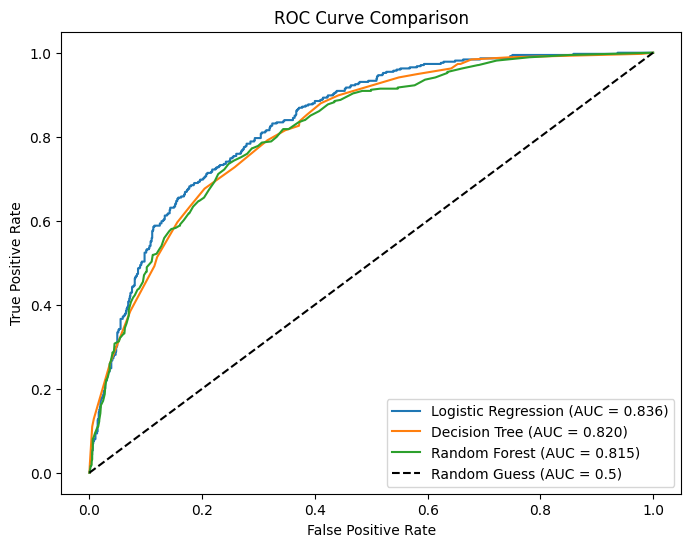

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Step 1: Create Comparison Table ---
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
     'Accuracy': [0.7306, 0.7029, 0.7604],
    'Precision': [0.4953, 0.4658, 0.5408],
    'Recall': [0.6979, 0.8021, 0.6550],
    'F1 Score': [0.5794, 0.5893, 0.5925],
    "ROC-AUC": [0.8148, 0.8230, 0.8150]
})

print("Model Performance Comparison:\n")
print(comparison)

# --- Step 2: Plot ROC Curves ---
# Probabilities must be available for each model
y_pred_prob_log = log_reg.predict_proba(X_test)[:, 1]
y_pred_prob_tree = dt_model.predict_proba(X_test)[:, 1]
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC values
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob_log)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

auc_log = roc_auc_score(y_test, y_pred_prob_log)
auc_tree = roc_auc_score(y_test, y_pred_prob_tree)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {auc_tree:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")

plt.plot([0,1],[0,1],'k--', label="Random Guess (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


Insights from the Table:

Decision Tree's Strength is Recall: The Decision Tree model achieved the highest Recall score at 0.8021. This means it was the best at correctly identifying actual churners, catching over 80% of them. This is an extremely valuable trait for a business focused on proactive retention.

Random Forest's Strength is Balance: The Random Forest model achieved the highest F1 Score at 0.5925 and the highest Precision at 0.5408. This indicates that while it didn't catch as many churners as the Decision Tree, its predictions were more reliable. 
This balance is often preferred in a business setting to avoid wasting resources on "false alarms" (customers incorrectly flagged as churners).

Logistic Regression's Performance: The Logistic Regression model performed well but was slightly outperformed by the Decision Tree on Recall and by the Random Forest on Precision and F1 Score.

In [82]:
import joblib

# Load models
log_reg = joblib.load("logistic_churn_model.pkl")
dt_model = joblib.load("decision_tree_churn_model.pkl")
best_rf_model = joblib.load("best_random_forest_churn_model.pkl")

# Load scaler
scaler = joblib.load("scaler.pkl")

In [83]:
import joblib

# Save models
joblib.dump(log_reg, "logistic_churn_model.pkl")
joblib.dump(dt_model, "decision_tree_churn_model.pkl")
joblib.dump(best_rf_model, "random_forest_churn_model.pkl")  # Changed here

# Save scaler
joblib.dump(scaler, "scaler.pkl")

print(" Models and scaler saved successfully!")

 Models and scaler saved successfully!
